In [2]:
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
from transcript_functions import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Reading in proxy statements for Walmart from 2010 through 2019, reading each page of each PDF document as a separate row in the dataframe.

In [3]:
df = pd.DataFrame(columns = ['raw_text','year'])

for k in range(10,20):

    pdfReader = PyPDF2.PdfFileReader("C:/Users/rawin/Documents/GitHub/Capstone-Project/Proxies/20%s_proxy.pdf"%(k))
    
    year = "20%s"%(k)
    
    NumPages = pdfReader.getNumPages()
    
    sub_df = pd.DataFrame(columns = ['raw_text','year'])
    for i in range(1, NumPages):
        pageObj = pdfReader.getPage(i)
        page = pageObj.extractText()
        page = page.replace('\n \n',', ')
        page = page.replace('\n','')
        page = page.replace('\d+', '')
        sub_df = sub_df.append({'raw_text':page,'year':year},ignore_index=True)
        
    df = pd.concat([df,sub_df],ignore_index=True)

In [4]:
df.shape

(966, 2)

In [6]:
#tokenize
df["tokens"] = df["raw_text"].map(nltk.word_tokenize)

#make lowercase
df["tokens_clean"] = df["tokens"].map(lambda x: [word.lower() for word in x])

#remove stopwords
stop_words = set(stopwords.words('english'))
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word not in stop_words])

In [7]:
# tag Part of Speech
df["tokens_pos"] = df["tokens_clean"].map(nltk.pos_tag)
# filter words with pos not in pos_keep
pos_keep = ["NN", "NNS","VB", "VBD", "VBN", "VBP", "VBZ"] #take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_keep])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

df["corpus"] = df["tokens_pos"].map(lambda x: ' '.join(x))

#remove numbers
df['corpus'] = df['corpus'].str.replace('\d+', '')

#tokenize
df["tokens_final"] = df["corpus"].map(nltk.word_tokenize)

#remove punctuation
punctuation = ['(',')',';',':','[',']',',','.',"''",'$','%','``',"’",".//","”"]
df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if word not in punctuation])

In [8]:
remove_words =['shareholders™','walmart','board','mr.','director','walton','committee','proxy','meeting','share','vote','shareholder','stock','plan']

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if word.lower() not in remove_words])

In [9]:
import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [10]:
dictionary = gensim.corpora.Dictionary(df["tokens_final"])

dictionary.filter_extremes(no_below=1, no_above=0.5) #, keep_n=100000)

bow_corpus = [dictionary.doc2bow(word) for word in df["tokens_final"]]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, 
                                       passes=2, workers=2, chunksize=100, random_state=1000)

In [11]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.029*"hold" + 0.018*"include" + 0.016*"c." + 0.016*"amount" + '
        '0.015*"officer" + 0.015*"defer" + 0.014*"trust" + 0.012*"executive" + '
        '0.012*"power" + 0.011*"robson"'),
    (   1,
        '0.012*"performance" + 0.008*"management" + 0.006*"jr." + 0.005*"cash" '
        '+ 0.005*"member" + 0.004*"ecommerce" + 0.004*"list" + 0.004*"rule" + '
        '0.004*"transfer" + 0.004*"skill"'),
    (   2,
        '0.051*"risk" + 0.035*"management" + 0.014*"ecommerce" + '
        '0.011*"compensation" + 0.010*"information" + 0.010*"process" + '
        '0.010*"oversight" + 0.009*"role" + 0.008*"innovation" + '
        '0.008*"technology"'),
    (   3,
        '0.027*"member" + 0.018*"serve" + 0.016*"experience" + '
        '0.016*"management" + 0.015*"service" + 0.015*"audit" + '
        '0.014*"chairman" + 0.014*"leadership" + 0.013*"business" + '
        '0.011*"governance"'),
    (   4,
        '0.025*"proposal" + 0.023*"statement" + 0.015*"governance" + '

In [69]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [92]:
# pyLDAvis.show(vis)

In [14]:
df.columns

Index(['raw_text', 'year', 'tokens', 'tokens_clean', 'tokens_pos', 'corpus',
       'tokens_final'],
      dtype='object')

## Finding the dominant topic in each page

In [15]:
def format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']]):
    # Init output
    page_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                page_topics_df = page_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    page_topics_df.columns = ['topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    page_topics_df = pd.concat([texts,page_topics_df], axis=1)
    return(page_topics_df)


df_topic_pages_keywords = format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']])

# Format
df_dominant_topic = df_topic_pages_keywords.reset_index()
df_dominant_topic = df_dominant_topic.drop('index',axis=1)

# Show
df_dominant_topic.tail(10)

,year,tokens_final,topic,perc_contribution,topic_keywords
956,2019,"[information, receive, notice, notification, a...",14.0,0.9862,"material, receive, instruction, statement, hol..."
957,2019,"[information, submission, inclusion, material,...",6.0,0.5339,"compensation, performance, amount, column, def..."
958,2019,"[abbreviationsthe, abbreviation, use, cer˜ain,...",7.0,0.8901,"compensation, sale, calculate, currency, measu..."
959,2019,"[abbreviation, list, company, rulesthe, nyse™s...",7.0,0.8479,"compensation, sale, calculate, currency, measu..."
960,2019,"[measurescer˜ain, measure, discuss, caption, h...",7.0,0.8702,"compensation, sale, calculate, currency, measu..."
961,2019,"[a-annex, reconciliation, reconciliation, comp...",7.0,0.9245,"compensation, sale, calculate, currency, measu..."
962,2019,"[measuresthe, company, use, per˚ormance, metri...",7.0,0.9953,"compensation, sale, calculate, currency, measu..."
963,2019,"[a-annex, calculate, adjust, income, interest,...",7.0,0.5717,"compensation, sale, calculate, currency, measu..."
964,2019,"[direction, associate/shareholder, meetingplac...",8.0,0.8796,"lot, time, use, center, statement, arkansas, p..."
965,2019,[],0.0,0.0667,"hold, include, c., amount, officer, defer, tru..."


In [16]:
df_dominant_topic.shape

(966, 5)

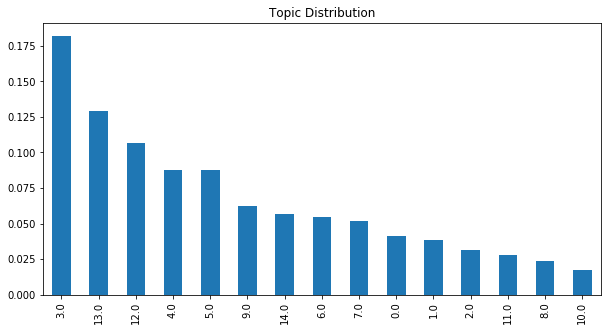

In [17]:
topic_counts = df_dominant_topic["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="Percentage",
                                       title="Topic Distribution",
                                       kind="bar", figsize=(10,5))

## Topic Trends

In [56]:
df_trend = pd.crosstab(df_dominant_topic["year"], df_dominant_topic["topic"], normalize="index")
years = [str(x) for x in df_trend.index]

In [57]:
df_trend

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
year,,,,,,,,,,,,,,,
2010,0.031579,0.126316,0.084211,0.084211,0.063158,0.063158,0.042105,0.094737,0.052632,0.031579,0.073684,0.084211,0.073684,0.021053,0.073684
2011,0.031250,0.203125,0.093750,0.015625,0.078125,0.078125,0.015625,0.078125,0.062500,0.031250,0.062500,0.078125,0.093750,0.015625,0.062500
2012,0.059701,0.119403,0.074627,0.059701,0.074627,0.104478,0.059701,0.059701,0.104478,0.029851,0.044776,0.044776,0.134328,0.000000,0.029851
2013,0.037975,0.025316,0.000000,0.227848,0.126582,0.088608,0.050633,0.012658,0.012658,0.075949,0.000000,0.012658,0.113924,0.177215,0.037975
2014,0.073684,0.010526,0.031579,0.178947,0.105263,0.084211,0.073684,0.052632,0.010526,0.084211,0.000000,0.010526,0.042105,0.168421,0.073684
2015,0.048780,0.008130,0.024390,0.178862,0.081301,0.073171,0.073171,0.032520,0.008130,0.048780,0.008130,0.016260,0.203252,0.138211,0.056911
2016,0.054054,0.000000,0.018018,0.207207,0.081081,0.081081,0.054054,0.045045,0.009009,0.063063,0.009009,0.018018,0.162162,0.162162,0.036036
2017,0.026087,0.000000,0.008696,0.269565,0.078261,0.086957,0.060870,0.043478,0.008696,0.086957,0.008696,0.017391,0.060870,0.191304,0.052174
2018,0.018692,0.000000,0.009346,0.224299,0.093458,0.093458,0.046729,0.046729,0.009346,0.084112,0.000000,0.009346,0.084112,0.205607,0.074766


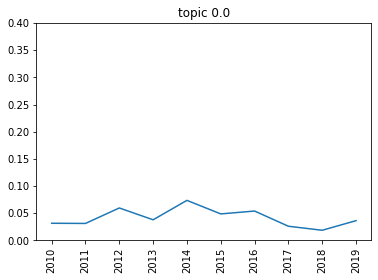

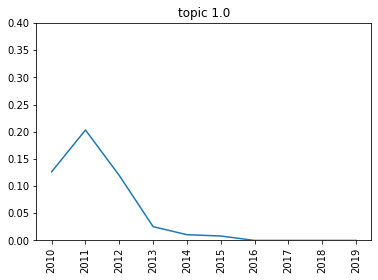

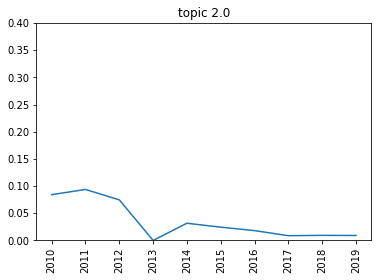

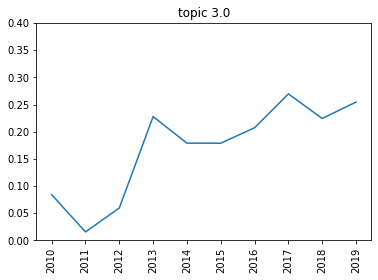

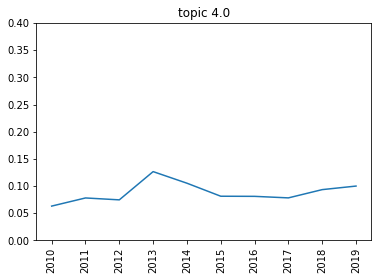

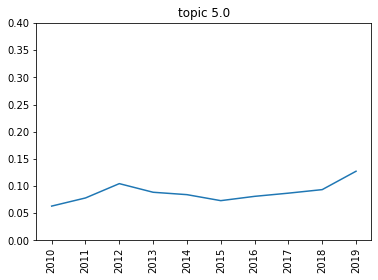

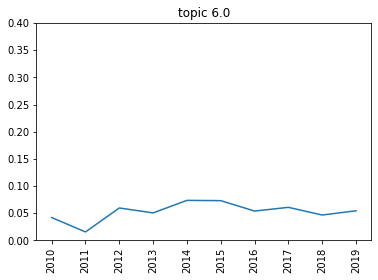

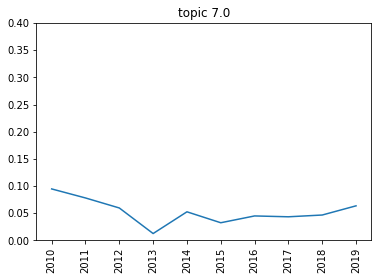

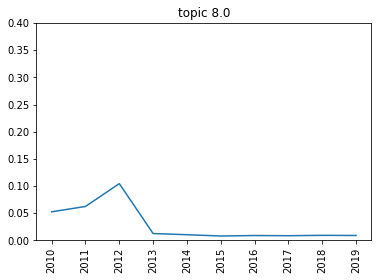

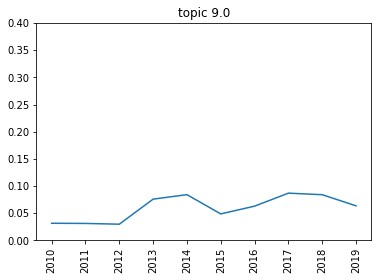

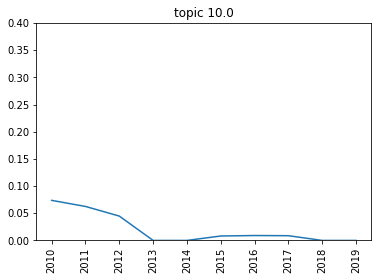

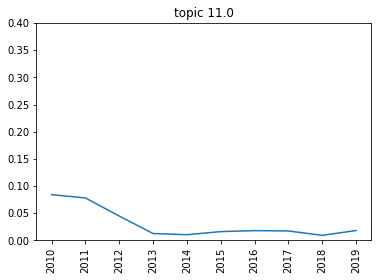

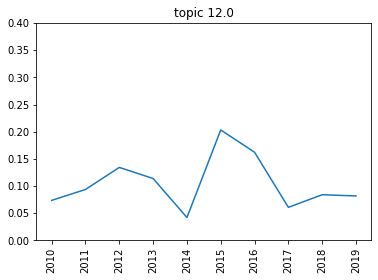

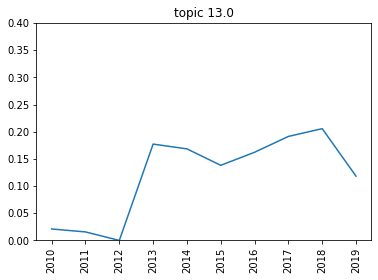

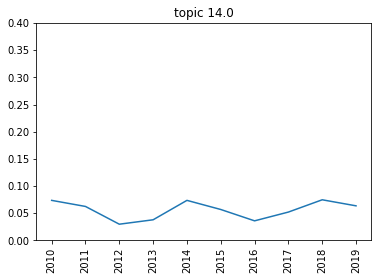

In [20]:
for topic in df_trend:
    fig, ax = plt.subplots()
    plt.plot(years, df_trend[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))

### Checking for correlation with CPI 

Data is Consumer Price Index for all items less medical care in the US

In [89]:
df_cpi = pd.read_csv('CPI.csv')
df_cpi.columns = ['date','cpi']

In [58]:
df_trend = df_trend.reset_index()
df_trend_new = df_trend.drop('year', axis=1)

In [67]:
df_trend_new.corrwith(df_cpi['cpi'])

topic
0.0    -0.435912
1.0     0.504161
2.0     0.353564
3.0    -0.312309
4.0    -0.073544
5.0     0.220736
6.0    -0.701844
7.0     0.425159
8.0     0.377258
9.0    -0.026215
10.0    0.339278
11.0    0.376256
12.0   -0.637755
13.0   -0.251141
14.0    0.210306
dtype: float64

Topic 6 shows some negative correlation with CPI at -0.702

### Checking for correlation with Labor Force Statistics/Unemployment Rate

In [88]:
labor = pd.read_excel('LaborForceStats.xlsx')

In [90]:
labor['avg'] = labor[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']].mean(axis=1)
labor

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,avg
0,2010,9.8,9.8,9.9,9.9,9.6,9.4,9.4,9.5,9.5,9.4,9.8,9.3,9.608333
1,2011,9.1,9.0,9.0,9.1,9.0,9.1,9.0,9.0,9.0,8.8,8.6,8.5,8.933333
2,2012,8.3,8.3,8.2,8.2,8.2,8.2,8.2,8.1,7.8,7.8,7.7,7.9,8.075000
3,2013,8.0,7.7,7.5,7.6,7.5,7.5,7.3,7.2,7.2,7.2,6.9,6.7,7.358333
4,2014,6.6,6.7,6.7,6.2,6.3,6.1,6.2,6.1,5.9,5.7,5.8,5.6,6.158333
5,2015,5.7,5.5,5.4,5.4,5.6,5.3,5.2,5.1,5.0,5.0,5.1,5.0,5.275000
6,2016,4.9,4.9,5.0,5.0,4.8,4.9,4.8,4.9,5.0,4.9,4.7,4.7,4.875000
7,2017,4.7,4.6,4.4,4.4,4.4,4.3,4.3,4.4,4.2,4.1,4.2,4.1,4.341667
8,2018,4.1,4.1,4.0,4.0,3.8,4.0,3.8,3.8,3.7,3.8,3.7,3.9,3.891667
9,2019,4.0,3.8,3.8,3.6,3.6,3.7,3.7,3.7,3.5,3.6,3.5,3.5,3.666667


In [85]:
df_trend_new.corrwith(labor['avg'])

topic
0.0     0.115086
1.0     0.863106
2.0     0.834569
3.0    -0.850964
4.0    -0.287179
5.0    -0.485324
6.0    -0.477582
7.0     0.473844
8.0     0.734313
9.0    -0.718813
10.0    0.845759
11.0    0.828278
12.0   -0.049429
13.0   -0.778017
14.0   -0.069853
dtype: float64

High positive correlation of Topics 1,2,10,and 11 with Labor Force Statistics. High negative correlation with Topic 3.

### Checking for correlation with WMT Stock Price